In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data


In [5]:
def standardize_columns(df, columns):
    scaler = MinMaxScaler(feature_range=(0,1))
    df_copy = df.copy()
    df_copy[columns] = scaler.fit_transform(df[columns])
    stats = {
        col: {"mean": scaler.data_min_[i], "std": scaler.data_range_[i]}
        for i, col in enumerate(columns)
    }
    return df_copy, stats

def standardize_test_data(df, columns, stats):
    df_copy = df.copy()
    for col in columns:
        if col not in stats:
            raise ValueError(f"Statistics for column '{col}' not found in the provided stats.")
        if col not in df_copy.columns:
            raise ValueError(f"Column '{col}' not found in the test DataFrame.")
        
        min_val = stats[col]["mean"]
        range_val = stats[col]["std"]
        
        df_copy[col] = (df_copy[col] - min_val) / range_val

    return df_copy


In [6]:
def split_data(scaled_set, train_percentage=0.8, window_size=30):
    train_end_index = int(len(scaled_set) * train_percentage)

    X_train, y_train = [], []
    for i in range(window_size, train_end_index):
        X_train.append(scaled_set[i-window_size:i])
        y_train.append(scaled_set[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test, y_test = [], []
    for i in range(train_end_index, len(scaled_set)):
        X_test.append(scaled_set[i-window_size:i])
        y_test.append(scaled_set[i])
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    return X_train, y_train, X_test, y_test


In [20]:
df = get_data('META', granularity='daily')
df.drop(columns=['Title'], inplace=True)
df = df.sort_values(by="Date", ascending=False)

df.head()

Adding Symbol: META
entry already exists or no title


,Date,Open,High,Low,Close,Adj_close,Volume
0,2025-02-28,658.04,669.63,642.60,668.20,668.20,17517800
1,2025-02-27,682.45,688.65,657.57,658.24,658.24,12500000
2,2025-02-26,659.65,683.01,658.00,673.70,673.70,14488700
3,2025-02-25,665.97,668.00,641.86,657.50,657.50,20579700
4,2025-02-24,686.28,687.27,662.45,668.13,668.13,15677000


In [21]:

columns_to_standardize = ['Open']  # Remplacez par les colonnes appropriées
df_standardized, stats = standardize_columns(df, columns_to_standardize)

# Préparation des données d'entraînement
train_set = df_standardized['Open'].values.reshape(-1, 1)  # Sélectionnez la colonne 'Open'

# Utilisation de la fonction split_data
X_train, y_train, X_test, y_test = split_data(train_set, train_percentage=0.8, window_size=30)

# Reshape pour correspondre à l'entrée du modèle PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Affichage des dimensions des ensembles
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


torch.Size([2541, 30, 1])
torch.Size([2541, 1])
torch.Size([643, 30, 1])
torch.Size([643, 1])


In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=4, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c_0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

# Initialisation du modèle
input_size = 1  
hidden_size = 50
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)


In [23]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 100
batch_size = 32

# Entraînement du modèle
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.0060
Epoch [2/100], Loss: 0.0054
Epoch [3/100], Loss: 0.0060
Epoch [4/100], Loss: 0.0002
Epoch [5/100], Loss: 0.0122
Epoch [6/100], Loss: 0.0150
Epoch [7/100], Loss: 0.0161
Epoch [8/100], Loss: 0.0170
Epoch [9/100], Loss: 0.0158
Epoch [10/100], Loss: 0.0010
Epoch [11/100], Loss: 0.0001
Epoch [12/100], Loss: 0.0003
Epoch [13/100], Loss: 0.0021
Epoch [14/100], Loss: 0.0041
Epoch [15/100], Loss: 0.0016
Epoch [16/100], Loss: 0.0018
Epoch [17/100], Loss: 0.0032
Epoch [18/100], Loss: 0.0007
Epoch [19/100], Loss: 0.0012
Epoch [20/100], Loss: 0.0004
Epoch [21/100], Loss: 0.0006
Epoch [22/100], Loss: 0.0003
Epoch [23/100], Loss: 0.0002
Epoch [24/100], Loss: 0.0004
Epoch [25/100], Loss: 0.0004
Epoch [26/100], Loss: 0.0003
Epoch [27/100], Loss: 0.0002
Epoch [28/100], Loss: 0.0005
Epoch [29/100], Loss: 0.0005
Epoch [30/100], Loss: 0.0005
Epoch [31/100], Loss: 0.0004
Epoch [32/100], Loss: 0.0003
Epoch [33/100], Loss: 0.0003
Epoch [34/100], Loss: 0.0005
Epoch [35/100], Loss: 0

Train MAE: 0.0414, Train MSE: 0.0024


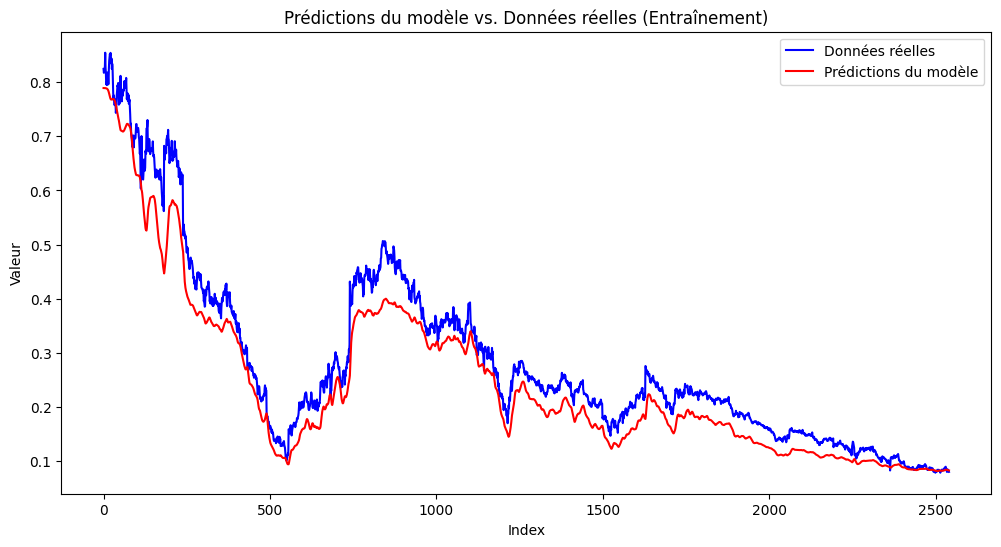

Test MAE: 0.0262, Test MSE: 0.0011


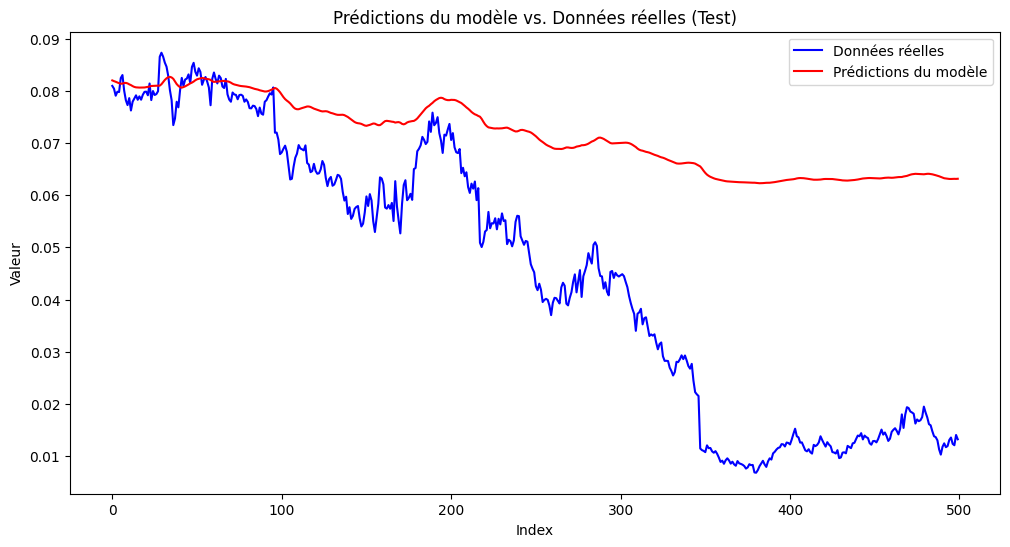

In [28]:
# Évaluation sur les données d'entraînement
model.eval()
with torch.no_grad():
    train_predictions = model(X_train).cpu().numpy()
    actual_train = y_train.cpu().numpy()

    mae = mean_absolute_error(actual_train, train_predictions)
    mse = mean_squared_error(actual_train, train_predictions)
    print(f'Train MAE: {mae:.4f}, Train MSE: {mse:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(actual_train)), actual_train, color='blue', label='Données réelles')
    plt.plot(np.arange(len(train_predictions)), train_predictions, color='red', label='Prédictions du modèle')
    plt.title('Prédictions du modèle vs. Données réelles (Entraînement)')
    plt.xlabel('Index')
    plt.ylabel('Valeur')
    plt.legend()
    plt.show()

# Évaluation sur les données de test
length = 500
with torch.no_grad():
    test_predictions = model(X_test).cpu().numpy()[:length]
    actual_test = y_test.cpu().numpy()[:length]

    test_mae = mean_absolute_error(actual_test, test_predictions)
    test_mse = mean_squared_error(actual_test, test_predictions)
    print(f'Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(actual_test)), actual_test, color='blue', label='Données réelles')
    plt.plot(np.arange(len(test_predictions)), test_predictions, color='red', label='Prédictions du modèle')
    plt.title('Prédictions du modèle vs. Données réelles (Test)')
    plt.xlabel('Index')
    plt.ylabel('Valeur')
    plt.legend()
    plt.show()
